In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [3]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)



    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128

        out = self.classifier(out) #100,10

        return out


In [4]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Linear(144, 16)
        
        self.fc1 = nn.Linear(16, 3)
        
        self.fc2 = nn.Linear(3, n_class)



    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        out1=self.fc1(out)
        
        out=self.fc2(out1)

        return out1

In [5]:
cnnmodel = Cnn(1, 1)
cnnmodel.load_state_dict(torch.load('./weathercnn-0.01-true-7.17.pth'))


cnnmodel.eval()
    
#test_x=torchds[:30700,0:8]
test_x=torchds[:30700,0:8]

test_x=test_x.view(-1,1,1,8)

#test_y=torchds[:30700,8]
test_y=torchds[:30700,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

cnnout = cnnmodel(test_x) #####8

In [6]:
cnnout.size()

torch.Size([30700, 3])

In [7]:
rnnmodel = Rnn(3, 5, 2, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(rnnmodel.parameters(), lr=0.1) ####速度很快

In [8]:
train_dataset =cnnout  ##0.7*43823  8
test_dataset  =test_y
dltrain = DataLoader(train_dataset, batch_size=100, shuffle=False)
dltest  = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [9]:
#%%time 
losslist=[]
start = time.clock()
for epoch in range(200):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0
    
    dldata=zip(dltrain,dltest)  #cnnout,trainy0.7

    for i, data in enumerate(dldata, 1):
        
            train_x=data[0][:,:]
            
            train_x=train_x.view(-1,1,3)
            
            train_y=data[1][:,0]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = rnnmodel(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)
            

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))  
print(time.clock()-start) #117.3018567  2-293.7432698  246.2105962

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


epoch 1
**********
running_loss:-------
0.008414020850012194
epoch 2
**********
running_loss:-------
0.008404434741585037
epoch 3
**********
running_loss:-------
0.008393240542955323
epoch 4
**********
running_loss:-------
0.008382365342452576
epoch 5
**********
running_loss:-------
0.008371723922828807
epoch 6
**********
running_loss:-------
0.008361236123887273
epoch 7
**********
running_loss:-------
0.008350825461045937
epoch 8
**********
running_loss:-------
0.008340417717735917
epoch 9
**********
running_loss:-------
0.00832994012869303
epoch 10
**********
running_loss:-------
0.008319318974625732
epoch 11
**********
running_loss:-------
0.008308480027683855
epoch 12
**********
running_loss:-------
0.00829734626628651
epoch 13
**********
running_loss:-------
0.008285837189475656
epoch 14
**********
running_loss:-------
0.00827386727114246
epoch 15
**********
running_loss:-------
0.008261344631679176
epoch 16
**********
running_loss:-------
0.008248169333177258
epoch 17
**********


0.0007024254932834089
epoch 132
**********
running_loss:-------
0.0007024200729912386
epoch 133
**********
running_loss:-------
0.0007024147144380573
epoch 134
**********
running_loss:-------
0.0007024094274238925
epoch 135
**********
running_loss:-------
0.0007024041119813525
epoch 136
**********
running_loss:-------
0.0007023989091739543
epoch 137
**********
running_loss:-------
0.0007023936942557605
epoch 138
**********
running_loss:-------
0.0007023885195567849
epoch 139
**********
running_loss:-------
0.0007023834380232471
epoch 140
**********
running_loss:-------
0.0007023783807231513
epoch 141
**********
running_loss:-------
0.000702373363037919
epoch 142
**********
running_loss:-------
0.0007023683721694492
epoch 143
**********
running_loss:-------
0.0007023633595916074
epoch 144
**********
running_loss:-------
0.0007023583325448011
epoch 145
**********
running_loss:-------
0.0007023534282531167
epoch 146
**********
running_loss:-------
0.0007023485751301376
epoch 147
*********

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


246.2105962


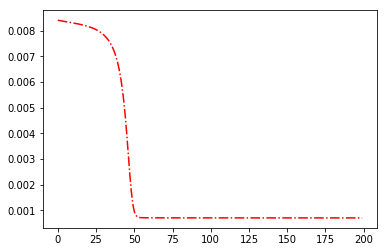

In [10]:
plt.plot(losslist,'r-.') 
plt.show()

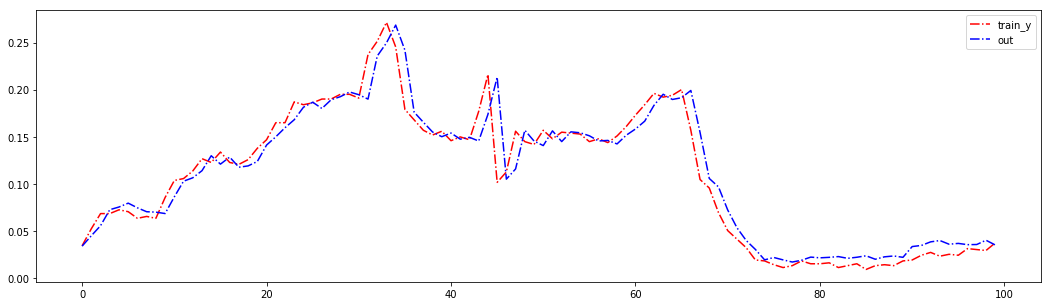

In [11]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.detach().numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [12]:
rnnmodel.eval()
    
test_x=torchds[30700:,0:8]

test_x=test_x.view(-1,1,1,8)

test_y=torchds[30700:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

testout = cnnmodel(test_x)

testout=testout.view(-1,1,3)

lstmtestout=rnnmodel(testout)

In [13]:
####计算准确率
acc=0
for i in range(13123):
    x=test_y.numpy()[i]-lstmtestout.detach().numpy()[i]
    if abs(x)<=0.02:
        acc+=1
accuracy_rate=acc/13123
print(accuracy_rate)  ##0.8242017831288577  0.8254972186237903 0.8261830374152251

0.8261830374152251


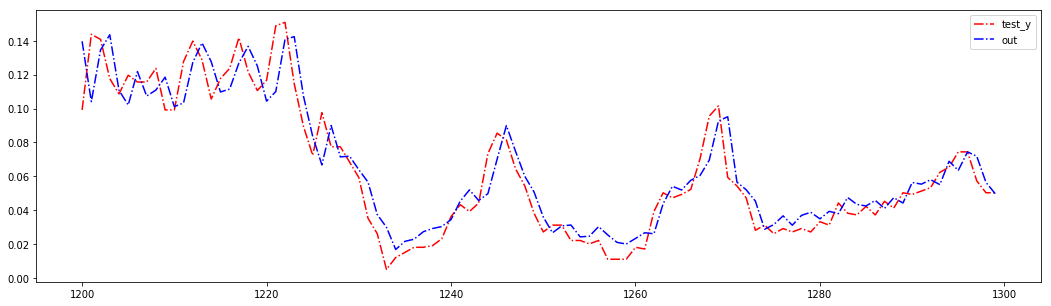

In [14]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.detach().numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,lstmtestout.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [15]:
# 保存模型
torch.save(rnnmodel.state_dict(), './weathercnn-lstm-0.1-false-7.17.pth')